**Descrição**

Aplica o algoritmo t-SNE sobre imagens multidimensionais para possibilitar a comparação entre estas e assim criar aglomerados de imagens semelhantes como resultado. 

O algoritmo usa imagens de tamanho arbitrário de uma pasta no drive e um modelo já treinado para realizar a comparação entre elas.

Tem como resultado imagens dos aglomerados em 3D e 2D

## Imports

In [ ]:
!pip install rasterfairy
import os
import random
import rasterfairy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial import distance
from keras.preprocessing import image
from keras import models
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from google.colab import drive
drive.mount('/content/drive')

## Variáveis

In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/")
FASHION_TEST = os.path.join(ROOT_DIR, "TCC/fashion/")
FASHION_SEG_DIR = os.path.join(ROOT_DIR, 'TCC/Visualização/mascaras/moda/pessoa')
FASHION_INST_DIR = os.path.join(ROOT_DIR, 'TCC/Visualização/mascaras/moda/1')
MODA_DIR = os.path.join(ROOT_DIR, 'TCC/modanet/modanet/annotations/')
MODA_TEST = os.path.join(MODA_DIR, "test/")
MODA_SEG_DIR = os.path.join(ROOT_DIR, 'TCC/Visualização/mascaras/pessoa')
MODA_INST_DIR = os.path.join(ROOT_DIR, 'TCC/Visualização/mascaras/1')
image_extensions = ['.jpg', '.png', '.jpeg']
max_num_images = 200
#n_components == min(n_samples, n_features) - 1

## Funções

In [ ]:
def load_preprocess_image(path, model="inception"):
    '''
    Lê imagens de um caminho e aplica o pré-processamento necessário
    que o modelo exige para poderem ser usadas.
    
    Args:
      path(str) : Caminho da pasta contendo as imagens a serem usadas.
      model(str): Modelo usado, dependendo do modelo a dimensão da imagem de entrada muda.
    Retorna:
      img(image)          : image object
      img_array(np.array) : image array preprocessed to model
    '''
    if model == "inception":
      dim = 224
    else: #VGG
      dim = 299
    img = image.load_img(path, target_size=(dim, dim)) 
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array

## Modelo Pré-Treinado

In [ ]:
#VGG16
#model = VGG16(weights='imagenet', include_top=True)
#feat_extractor = models.Model(inputs=model.input, outputs=model.get_layer("fc2").output)
#feat_extractor.summary()

#Inception_v3
model = InceptionV3(include_top=True, weights='imagenet')
feat_extractor = models.Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)

#model.summary()














96116736/96112376 [==============================] - 3s 0us/step


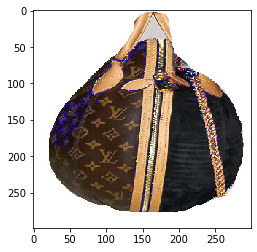

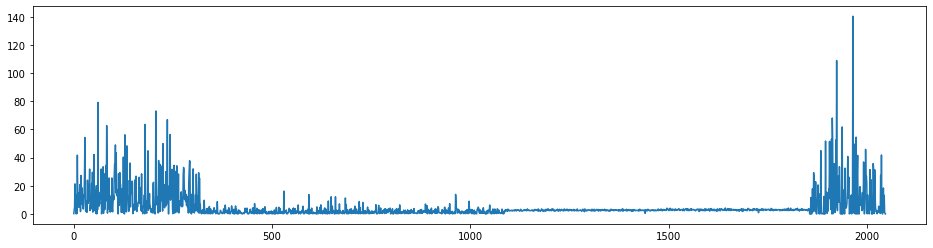

In [ ]:
# Teste de visualização de retorno da funçao
img, tensor = load_preprocess_image(os.path.join(FASHION_INST_DIR, '_ALE0105.jpg.jpg'))
feat = feat_extractor.predict(tensor)
plt.imshow(img)
plt.figure(figsize=(16,4))
plt.plot(feat[0])
plt.show()

In [ ]:
#images_path = MODA_TEST
images_path = FASHION_SEG_DIR
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]

if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

print("%d imagens para análise" % len(images))

186 imagens para análise


## Preprocessing

In [ ]:
features = []
for i, image_path in enumerate(images):
    img, img_array = load_image(image_path);
    feat = feat_extractor.predict(img_array)[0]
    features.append(feat)

### Redução de dimensão

In [ ]:
features = np.array(features)
print(features.shape)
pca = PCA(n_components=30)
pca.fit(features)

(186, 2048)


PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca_features = pca.transform(features)
to_tsne = np.array(pca_features)
print(pca_features.shape)

(186, 30)


### Visualiza comparação entre imagens compactas

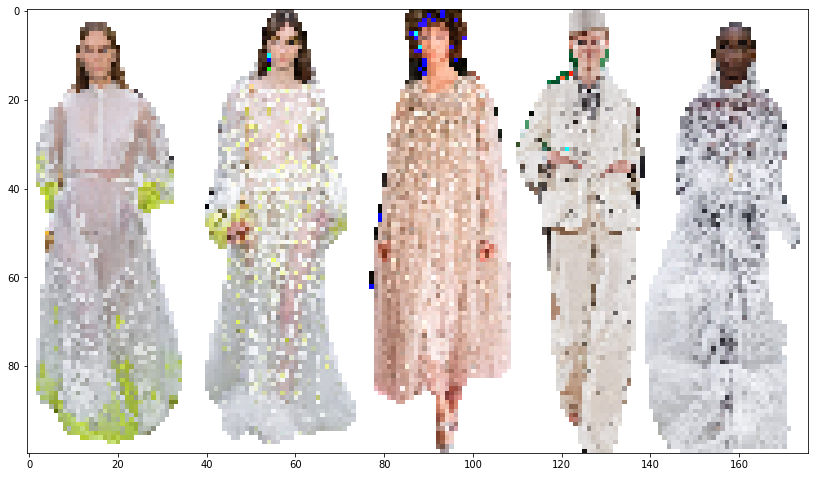

In [ ]:
# grab a random query image
query_image_idx = int(len(images) * random.random())
similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

# carrega resultado de similaridades como thumbnails de tamanho 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
plt.figure(figsize = (14,10))
plt.imshow(concat_image)

## Aplica t-SNE

In [ ]:
# num_images_to_plot = 200
# if len(images) > num_images_to_plot:
#     sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
#     images = [images[i] for i in sort_order]
#     pca_features = [pca_features[i] for i in sort_order]
tsne = TSNE(n_components=2, learning_rate=150, perplexity=20, angle=0.2, verbose=2).fit_transform(to_tsne)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 186 samples in 0.002s...
[t-SNE] Computed neighbors for 186 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 186 / 186
[t-SNE] Mean sigma: 37.677625
[t-SNE] Computed conditional probabilities in 0.012s
[t-SNE] Iteration 50: error = 66.0308990, gradient norm = 0.5461680 (50 iterations in 0.062s)
[t-SNE] Iteration 100: error = 66.7040024, gradient norm = 0.5934996 (50 iterations in 0.062s)
[t-SNE] Iteration 150: error = 63.9973869, gradient norm = 0.6311687 (50 iterations in 0.073s)
[t-SNE] Iteration 200: error = 64.1677628, gradient norm = 0.5886588 (50 iterations in 0.062s)
[t-SNE] Iteration 250: error = 65.0404205, gradient norm = 0.5681517 (50 iterations in 0.063s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.040421
[t-SNE] Iteration 300: error = 0.6831755, gradient norm = 0.0101847 (50 iterations in 0.059s)
[t-SNE] Iteration 350: error = 0.6221493, gradient norm = 0.0177746 

In [ ]:
#normalização
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

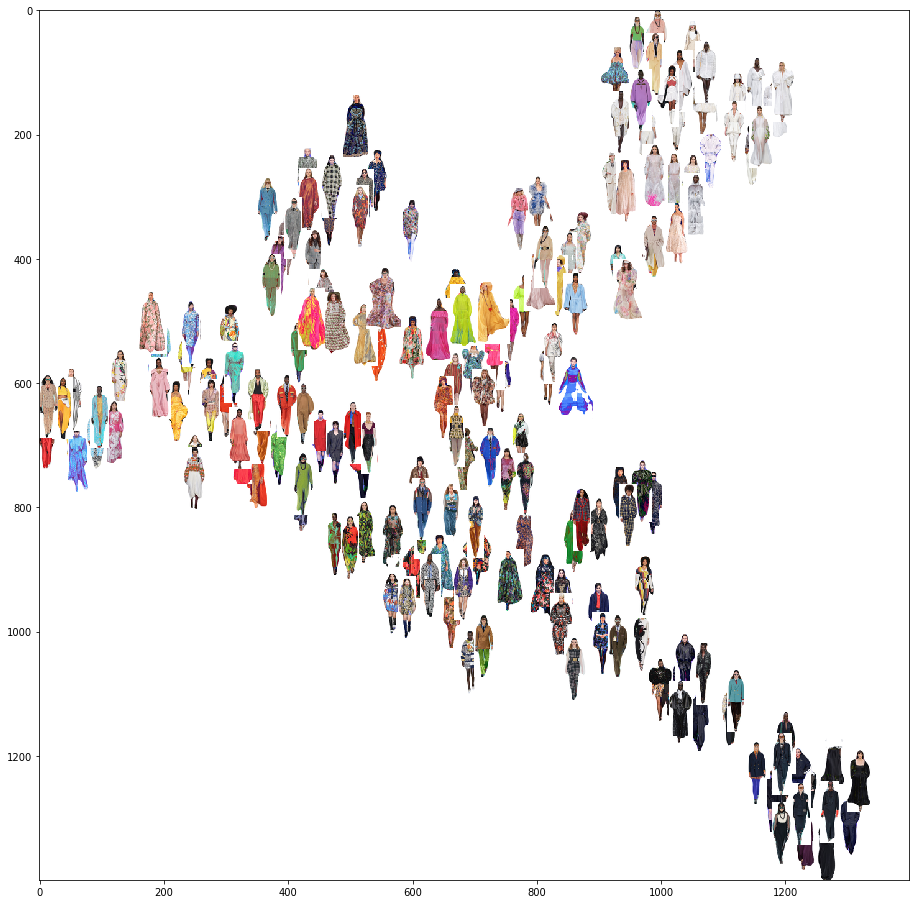

In [ ]:
width = 1400
height = 1400
max_dim = 100

full_image = Image.new('RGBA', (width, height))

for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (20,16))
plt.imshow(full_image)

## Reduz para grid 2D

In [ ]:
# nx * ny = the number of images
nx = 19 
ny = 10
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

In [ ]:
tile_width = 200
tile_height = 400
full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

plt.figure(figsize = (28,20))
plt.imshow(grid_image)

Output hidden; open in https://colab.research.google.com to view.